## Annotation analisys (linking)

This notebook is an attempt to compute dynamic statistics of the Superconductor dataset links and relationships.

In [1]:
import os
from pathlib import Path

from bs4 import BeautifulSoup, Tag
import os

In [2]:
def process_dir(input):
    accumulated_statistics = []
    abs_start = os.path.abspath(input)
    for root, dirs, files in os.walk(input):
        for file_ in files:
            if not file_.lower().endswith(".xml"):
                continue
            abs_path = os.path.join(root, file_)
#             print("Processing: " + str(abs_path))
            output_data = process_file(abs_path)
            output_data['path'] = os.path.relpath(abs_path, abs_start)
            accumulated_statistics.append(output_data)

    return accumulated_statistics


def get_relationship_name(source_label, destination_label):
    relationship_name = ""
    if str.lower(source_label) == 'tcvalue':
        if destination_label == 'material':
            relationship_name = 'tcValue-material'
        elif destination_label == 'me_method':
            relationship_name = 'me_method-tcValue'
        else:
            raise Exception("Something is wrong in the links. "
                        "The link between " + source_label + " and " + destination_label + " is invalid. ")
    elif str.lower(source_label) == 'pressure':
        if str.lower(destination_label) == 'tcvalue':
            relationship_name = 'tcValue-pressure'
    else:
        raise Exception("Something is wrong in the links. "
            "The link between " + source_label + " and " + destination_label + " is invalid. ")

    return relationship_name


def process_file(input):
#     print ("Processing file ", input)
    with open(input, encoding='utf-8') as fp:
        doc = fp.read()

    soup = BeautifulSoup(doc, 'xml')

    links_statistics = {}
    
    document_statistics = {
        'name': Path(input).name,
        'links': links_statistics,
        'links_number': 0,
        'links_same_paragraph': 0,
        'paragraphs': 0,
         # In this case we refer to material - tcValue, in particular paragraphs where there are not enough entities for linking
        'paragraphs_without_enough_relevant_entities': 0, 
         # In this case we refer to material - tcValue, having at least 1 material and 1 tcValue
        'paragraphs_with_enough_relevant_entities': 0, 
         # Number of paragraphs with at least one link inside 
        'paragraphs_with_links_inside' : 0
    }

    children = []
    for child in soup.tei.children:
        if child.name == 'teiHeader':
            children.append(child.find_all("title"))
            children.extend([subchild.find_all("p") for subchild in child.find_all("abstract")])
            children.append(child.find_all("ab", {"type": "keywords"}))
        elif child.name == 'text':
            children.append([subsubchild for subchild in child.find_all("body") for subsubchild in subchild.children if
                             type(subsubchild) is Tag])

    dic_dest_relationships = {}
    dic_source_relationships = {}
    ient = 1
    i = 0
    for child in children:
        for pTag in child:
            paragraphText = ''
            paragraph_materials = 0
            paragraph_tcValues = 0
            document_statistics['paragraphs'] += 1
            j = 0
            for item in pTag.contents:
                if type(item) is Tag:
                    if 'type' not in item.attrs:
                        raise Exception("RS without type is invalid. Stopping")
                    entity_class = item.attrs['type']

                    if entity_class == "material":
                        paragraph_materials += 1
                    if entity_class == "tcValue":
                        paragraph_tcValues += 1

                    if len(item.attrs) > 0:
                        if 'xml:id' in item.attrs:
                            if item.attrs['xml:id'] not in dic_dest_relationships:
                                dic_dest_relationships[item.attrs['xml:id']] = [i + 1, j + 1, ient, entity_class]

                        if 'corresp' in item.attrs:
                            if (i + 1, j + 1) not in dic_source_relationships:
                                dic_source_relationships[i + 1, j + 1] = [item.attrs['corresp'].replace('#', ''), ient,
                                                                          entity_class]

                    j += 1
                ient += 1

            if paragraph_materials > 0 and paragraph_tcValues > 0:
                document_statistics['paragraphs_with_enough_relevant_entities'] += 1
            else:
                document_statistics['paragraphs_without_enough_relevant_entities'] += 1
            i+=1

    paragraphs_with_links = []
    link_count = 0
    for par_num, token_num in dic_source_relationships:
        destination_xml_id = dic_source_relationships[par_num, token_num][0]
        source_entity_id = dic_source_relationships[par_num, token_num][1]
        source_label = dic_source_relationships[par_num, token_num][2]

        # destination_xml_id: Use this to pick up information from dic_dest_relationship

        for des in destination_xml_id.split(","):
            link_count+= 1
            destination_item = dic_dest_relationships[str(des)]
            destination_paragraph_tsv = destination_item[0]
            
            ## Same paragraph links
            if par_num == destination_paragraph_tsv: 
                document_statistics['links_same_paragraph'] += 1
                paragraphs_with_links.append(par_num)
                
            # destination_token_tsv = destination_item[1]
            # destination_entity_id = destination_item[2]
            destination_label = destination_item[3]

            relationship_name = get_relationship_name(source_label, destination_label)
            if relationship_name not in links_statistics:
                links_statistics[relationship_name] = 1
            else:
                links_statistics[relationship_name] += 1
                 
#     print(sum([links_statistics[rel] for rel in links_statistics.keys()]))
    link_count2 = sum([links_statistics[rel] for rel in links_statistics.keys()])
    if link_count != link_count2: 
        print(link_count, link_count2)
    document_statistics['links_number'] = sum([links_statistics[rel] for rel in links_statistics.keys()])
    document_statistics['paragraphs_with_links_inside'] = len(set(paragraphs_with_links))
    
    
    ## Cross check 
    
    if document_statistics['paragraphs'] != document_statistics['paragraphs_without_enough_relevant_entities'] + document_statistics['paragraphs_with_enough_relevant_entities']:
        print("Something is wrong with paragraph count: \n\t - paragraph count: " + str(document_statistics['paragraphs']) + "\n\t - paragraph without enough relevant entities: " + str(document_statistics['paragraphs_without_enough_relevant_entities']) + "\n\t - paragraph with enough relevant entities: " + str(document_statistics['paragraphs_with_enough_relevant_entities']))
    
    return document_statistics

Analysis 

In [3]:
def run_analysis(input):
    input_path = Path(input)
    documents_statistics = process_dir(input_path)

    aggregated_links = {}
    links_by_batch = {}
    links_same_paragraph = 0
    number_of_paragraphs = 0
    number_of_paragraphs_with_enough_relevant_entities = 0
    number_of_paragraphs_without_enough_relevant_entities = 0
    links_count = 0

    output_data = {
        'path': str(Path(input_path).absolute()),
        'files': len(documents_statistics),
        'aggregated': aggregated_links,
        'batches': links_by_batch
    }

    ## Summary of all articles

    for document_statistics in documents_statistics:
#         print(document_statistics)
        links_count += document_statistics['links_number']
        links_same_paragraph += document_statistics['links_same_paragraph']
        number_of_paragraphs += document_statistics['paragraphs']
#         print(str(number_of_paragraphs_with_enough_relevant_entities))
        number_of_paragraphs_with_enough_relevant_entities += document_statistics['paragraphs_with_enough_relevant_entities']
        number_of_paragraphs_without_enough_relevant_entities += document_statistics ['paragraphs_without_enough_relevant_entities']
        
        for link_name in document_statistics['links']:
            link_statistics = document_statistics['links'][link_name]
            if link_name not in aggregated_links:
                aggregated_links[link_name] = link_statistics
            else:
                aggregated_links[link_name] += link_statistics

    output_data['documents'] = documents_statistics
    output_data['paragraphs'] = number_of_paragraphs
    output_data['paragraphs_with_enough_relevant_entities'] = number_of_paragraphs_with_enough_relevant_entities
    output_data['paragraphs_without_enough_relevant_entities'] = number_of_paragraphs_without_enough_relevant_entities
    output_data['links_same_paragraph'] = links_same_paragraph
    output_data['links_number'] = links_count


    ## Summary by batch (assuming that the batch is the first directory)
    for document_statistics in documents_statistics:
        batch_name = os.path.dirname(document_statistics['path'])

        if batch_name not in links_by_batch:
            links_by_batch[batch_name] = {}

        for link_name in document_statistics['links']:
            link_statistics = document_statistics['links'][link_name]
            if link_name not in links_by_batch[batch_name]:
                links_by_batch[batch_name][link_name] = link_statistics
            else:
                links_by_batch[batch_name][link_name] += link_statistics

    output_data['batches'] = links_by_batch


    return output_data

Run Analysis 

In [4]:
input = "../data/annotated"
# input = "../corpus/staging/test/"
    
analysed_links = run_analysis(input)

# analysed_links

# Overview



In [5]:
columns=['total paragraphs', 'paragraphs with insufficient entities', 'paragraphs with enough entities', 'number of links', 'Number of links in the same paragraph']
rows = [analysed_links['paragraphs'], analysed_links['paragraphs_without_enough_relevant_entities'], analysed_links['paragraphs_with_enough_relevant_entities'], analysed_links['links_number'], analysed_links['links_same_paragraph']]

import pandas as pd
pd.DataFrame([rows], columns=columns)

,total paragraphs,paragraphs with insufficient entities,paragraphs with enough entities,number of links,Number of links in the same paragraph
0,3079,2584,495,1155,1049


## Summary 

In [6]:
analysed_links['aggregated']

{'tcValue-material': 837, 'me_method-tcValue': 190, 'tcValue-pressure': 128}

## Aggregated by link class

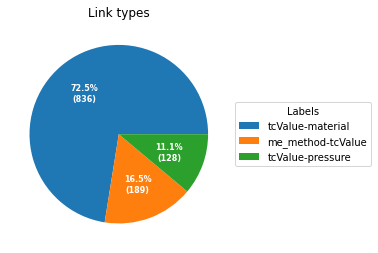

In [7]:
aggregated_frequency = analysed_links['aggregated']
# analysed_links['batches']

labels = []
values = []

for label in aggregated_frequency.keys(): 
    labels.append(label)
    values.append(aggregated_frequency[label])

    
## PIE
import matplotlib.pyplot as plt
import numpy as np

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)
    

fig, ax = plt.subplots(figsize=(4, 8), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: func(pct, values),
                                  textprops=dict(color="w"))


ax.legend(wedges, labels,
          title="Labels",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Link types")
plt.show()

## Aggregation by batch 


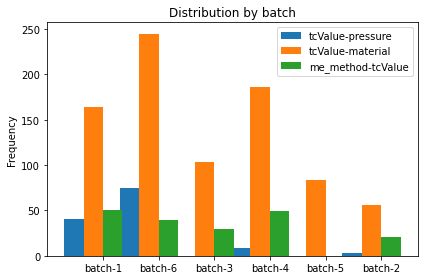

In [8]:
aggregated_frequency = analysed_links['batches']
# aggregated_frequency['batch-1']['me_method-tc'] =  22

#'batches': {
#  'batch-1': {'material-tc': 120, 'pressure-tc': 17},
#  'batch-3': {'material-tc': 57},
#  'batch-4': {'material-tc': 102, 'pressure-tc': 2},
#  'batch-2': {'material-tc': 34}
#}


## Compare various batches
labels = []
values = {}
link_names = set()

for batch_name in aggregated_frequency.keys():
    labels.append(batch_name)
    values[batch_name] = []
    for label in aggregated_frequency[batch_name].keys():
        link_names.add(label)

for link_name in link_names:
    for batch_name in labels:
        if link_name in aggregated_frequency[batch_name]:
            values[batch_name].append(aggregated_frequency[batch_name][link_name])
        else: 
            values[batch_name].append(0)
            

    
pass
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

for index, link_name in enumerate(link_names):
    data_points = []
    for batch in labels: 
        data_points.append(values[batch][index])

    position = (x - width*len(link_names)/2) + index * width    
    rects1 = ax.bar(position, data_points, width, label=link_name)
        

# rects2 = ax.bar(x + width/2, women_means, width, label='Women')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_title('Distribution by batch')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')



fig.tight_layout()

plt.show()
